In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.metrics import Recall, Precision
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from keras.applications import ResNet152V2  
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import SGD
from keras import layers
import multiprocessing

2023-05-12 21:06:07.105796: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-12 21:06:07.213470: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-12 21:06:07.215788: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 21:06:08.387315: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Define the path to the data directory
data_dir = "/media/DATA/pin"

# Define the paths to the train and test directories
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Define the input image size and number of classes
img_width = 224
img_height = 224
batch_size = 8

In [3]:
def visualize_data(train_dir, val_dir):
    train_counts = []
    val_counts = []
    labels = []

    for folder in os.listdir(train_dir):
        labels.append(folder)
        train_counts.append(len(os.listdir(os.path.join(train_dir, folder))))

    for folder in os.listdir(val_dir):
        val_counts.append(len(os.listdir(os.path.join(val_dir, folder))))

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 8))
    rects1 = ax.bar(x - width/2, train_counts, width, label='Train')
    rects2 = ax.bar(x + width/2, val_counts, width, label='Validation')

    ax.set_ylabel('Number of Images')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()

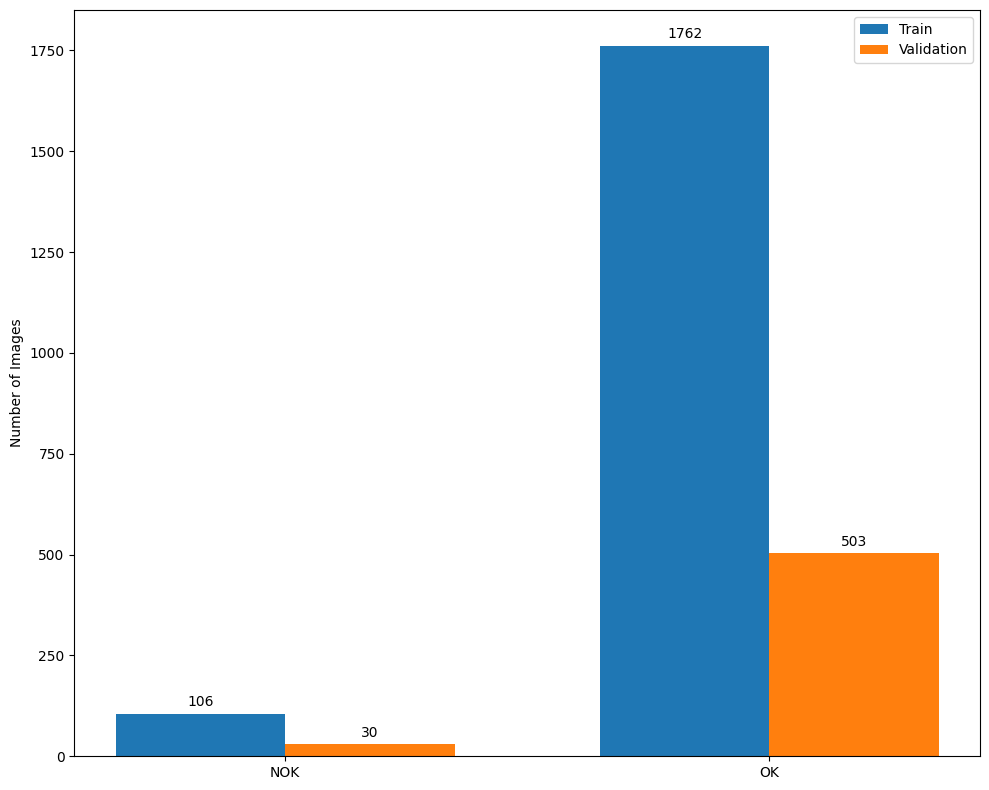

In [4]:
visualize_data(train_dir, val_dir)

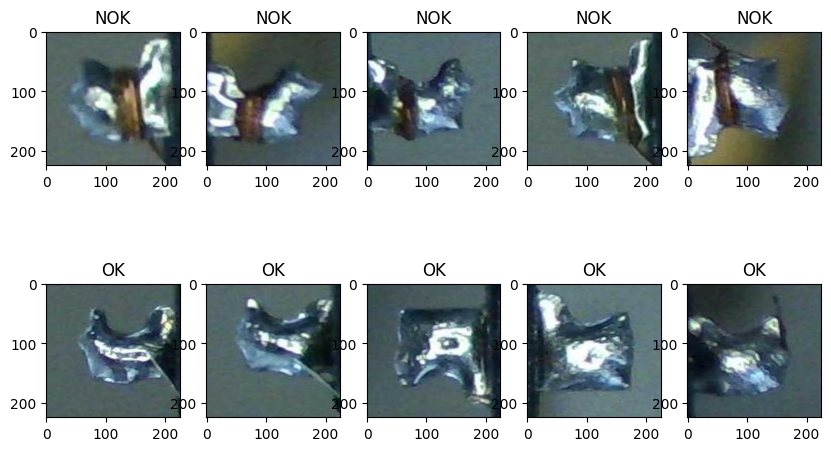

In [5]:
# Define the paths to the train directories for the "fail" and "pass" classes
fail_train_dir = os.path.join(data_dir, "train", "NOK")
pass_train_dir = os.path.join(data_dir, "train", "OK")

# Define the paths to a few images from each class
fail_images = [os.path.join(fail_train_dir, f) for f in os.listdir(fail_train_dir)[:5]]
pass_images = [os.path.join(pass_train_dir, f) for f in os.listdir(pass_train_dir)[:5]]

# Plot the images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 6))

for i, image_path in enumerate(fail_images):
    ax = axes[0, i]
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title("NOK")

for i, image_path in enumerate(pass_images):
    ax = axes[1, i]
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title("OK")

plt.show()

In [6]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
    rotation_range=20,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2
    )

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    seed=42,
    shuffle=True
    )

Found 1868 images belonging to 2 classes.


In [7]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    seed=42,
    shuffle=True
    )

Found 533 images belonging to 2 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["NOK", "OK"],
    shuffle = False,
    seed=42
    )

Found 269 images belonging to 2 classes.


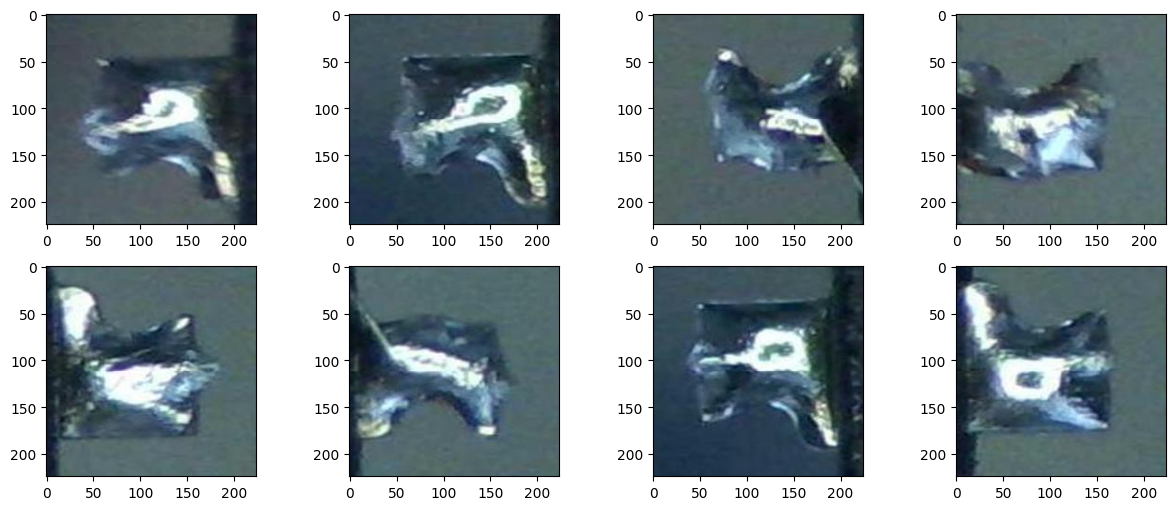

In [9]:
# Get a batch of images from the generator
img_batch, _ = train_data.next()

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(img_batch[i])
    ax.axis('on')
    
plt.show()

In [10]:
class_names = train_data.class_indices
class_names

{'NOK': 0, 'OK': 1}

In [11]:
# Get the class labels from the data generator
labels = train_data.classes

# Calculate the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data.classes), y=labels)

# Convert the class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

In [12]:
class_weight_dict

{0: 8.81132075471698, 1: 0.5300794551645857}

In [13]:
base_model = ResNet152V2(
        weights='imagenet', # Load pre-trained weights from the ImageNet dataset
        include_top=False, # Set to False to exclude the top fully connected layers from the model
        input_shape=(img_width, img_height, 3) # The input shape of the images
    )

gmp = GlobalAveragePooling2D()(base_model.output)

output = Dense(1, activation='sigmoid')(gmp)

model = Model(base_model.input, outputs=output)

In [14]:
for layer in base_model.layers:
    layer.trainable = False

In [15]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f0328953700>,input_1,False
1,<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f0325fd2460>,conv1_pad,False
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f0325fd2940>,conv1_conv,False
3,<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f0325fd2f10>,pool1_pad,False
4,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f0325f4e4c0>,pool1_pool,False
...,...,...,...
561,<keras.layers.merging.add.Add object at 0x7f032651a070>,conv5_block3_out,False
562,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f032651a4c0>,post_bn,False
563,<keras.layers.core.activation.Activation object at 0x7f03265223d0>,post_relu,False
564,<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f03265c7cd0>,global_average_pooling2d,True


In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block5_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block5_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block5_2_pad (ZeroPaddin  (None, 30, 30, 128)  0          ['conv3_block5_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv3_blo

                                                                  'conv3_block7_3_conv[0][0]']    
                                                                                                  
 conv3_block8_preact_bn (BatchN  (None, 28, 28, 512)  2048       ['conv3_block7_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv3_block8_preact_relu (Acti  (None, 28, 28, 512)  0          ['conv3_block8_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv3_block8_1_conv (Conv2D)   (None, 28, 28, 128)  65536       ['conv3_block8_preact_relu[0][0]'
                                                                 ]                                
          

 n)                                                                                               
                                                                                                  
 conv4_block2_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block2_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  589824      ['conv4_block2_2_pad[0][0]']     
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv4_block5_preact_bn (BatchN  (None, 14, 14, 1024  4096       ['conv4_block4_out[0][0]']       
 ormalization)                  )                                                                 
                                                                                                  
 conv4_block5_preact_relu (Acti  (None, 14, 14, 1024  0          ['conv4_block5_preact_bn[0][0]'] 
 vation)                        )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262144      ['conv4_block5_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block7_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block7_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block7_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block7_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_blo

 conv4_block10_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block10_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block10_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block10_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block10_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block10_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block10_1_relu[0][0]']   
 ng2D)    

                                                                                                  
 conv4_block12_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block12_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block12_out (Add)        (None, 14, 14, 1024  0           ['conv4_block11_out[0][0]',      
                                )                                 'conv4_block12_3_conv[0][0]']   
                                                                                                  
 conv4_block13_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block12_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_blo

 conv4_block15_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block15_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block15_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block15_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block15_2_pad[0][0]']    
                                                                                                  
 conv4_block15_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block15_2_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block18_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block17_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block18_preact_relu (Act  (None, 14, 14, 1024  0          ['conv4_block18_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block18_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block18_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_blo

 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block20_2_pad[0][0]']    
                                                                                                  
 conv4_block20_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block20_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block20_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block20_2_relu[0][0]']   
                                )                                                                 
          

                                                                                                  
 conv4_block23_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block23_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block23_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block23_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block23_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 on)                                                                                              
                                                                                                  
 conv4_block25_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block25_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block25_out (Add)        (None, 14, 14, 1024  0           ['conv4_block24_out[0][0]',      
                                )                                 'conv4_block25_3_conv[0][0]']   
                                                                                                  
 conv4_block26_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block25_out[0][0]']      
 Normalization)                 )                                                                 
          

                                                                                                  
 conv4_block28_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block28_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block28_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block28_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block28_2_pad[0][0]']    
                                                                                                  
 conv4_block28_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block28_2_conv[0][0]']   
 lization)

                                )                                 'conv4_block30_3_conv[0][0]']   
                                                                                                  
 conv4_block31_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block30_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block31_preact_relu (Act  (None, 14, 14, 1024  0          ['conv4_block31_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block31_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block31_preact_relu[0][0]
                                                                 ']                               
          

                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block33_2_pad[0][0]']    
                                                                                                  
 conv4_block33_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block33_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block33_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block33_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block33_2_relu[0][0]']   
          

 ivation)                       )                                                                 
                                                                                                  
 conv4_block36_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block36_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block36_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block36_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block36_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block36_1_bn[0][0]']     
 on)                                                                                              
          

 conv5_block2_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
          

In [17]:
recall = Recall()
precision = Precision()

In [18]:
optimizer = SGD(learning_rate=0.01, decay=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy', recall, precision])

In [19]:
early_stopping_cb = EarlyStopping(patience=3,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

In [20]:
EPOCHS = 10

num_workers = multiprocessing.cpu_count()
#workers=num_workers,
#use_multiprocessing=True,
#class_weight=class_weight_dict
history = model.fit(train_data, 
                      validation_data=val_data,
                      epochs=EPOCHS,
                      steps_per_epoch=(train_data.n//batch_size),
                      validation_steps=(val_data.n//batch_size),
                      callbacks=[early_stopping_cb],
                      class_weight=class_weight_dict
                  )

Epoch 1/10


2023-05-12 21:06:45.154845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


116/116 [==============================] - ETA: 0s - loss: 2.4118 - accuracy: 0.7160 - recall: 0.7172 - precision: 0.9751

2023-05-12 21:10:54.860142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


116/116 [==============================] - 321s 3s/step - loss: 2.4118 - accuracy: 0.7160 - recall: 0.7172 - precision: 0.9751 - val_loss: 0.4214 - val_accuracy: 0.9223 - val_recall: 0.9317 - val_precision: 0.9851
Epoch 2/10
116/116 [==============================] - 292s 3s/step - loss: 0.5779 - accuracy: 0.9104 - recall: 0.9107 - precision: 0.9937 - val_loss: 0.7840 - val_accuracy: 0.8371 - val_recall: 0.8313 - val_precision: 0.9952
Epoch 3/10
116/116 [==============================] - 299s 3s/step - loss: 0.2015 - accuracy: 0.9492 - recall: 0.9485 - precision: 0.9976 - val_loss: 0.2642 - val_accuracy: 0.9432 - val_recall: 0.9498 - val_precision: 0.9895
Epoch 4/10
116/116 [==============================] - 289s 2s/step - loss: 0.1446 - accuracy: 0.9611 - recall: 0.9605 - precision: 0.9982 - val_loss: 0.3737 - val_accuracy: 0.9205 - val_recall: 0.9257 - val_precision: 0.9893
Epoch 5/10
116/116 [==============================] - 299s 3s/step - loss: 0.1358 - accuracy: 0.9568 - recall: 

In [21]:
len(base_model.layers)

564

In [22]:
for layer in base_model.layers:
  layer.trainable = True

In [23]:
optimizer = SGD(learning_rate=0.001, decay=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy', recall, precision])

In [24]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
df = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 
df 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f0328953700>,input_1,True
1,<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f0325fd2460>,conv1_pad,True
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x7f0325fd2940>,conv1_conv,True
3,<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f0325fd2f10>,pool1_pad,True
4,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f0325f4e4c0>,pool1_pool,True
...,...,...,...
561,<keras.layers.merging.add.Add object at 0x7f032651a070>,conv5_block3_out,True
562,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f032651a4c0>,post_bn,True
563,<keras.layers.core.activation.Activation object at 0x7f03265223d0>,post_relu,True
564,<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f03265c7cd0>,global_average_pooling2d,True


In [25]:
df['Layer Trainable'].value_counts()[True]

566

In [26]:
early_stopping_cb = EarlyStopping(patience=10,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

In [27]:
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [28]:
checkpoint_cb = ModelCheckpoint('model_1.h5',
                                save_best_only=True,
                                monitor='val_loss',
                                mode='min')

In [29]:
EPOCHS = 100

num_workers = multiprocessing.cpu_count()

history = model.fit(train_data, 
                      validation_data=val_data,
                      epochs=EPOCHS,
                      steps_per_epoch=(train_data.n//batch_size),
                      validation_steps=(val_data.n//batch_size),
                      callbacks=[early_stopping_cb,checkpoint_cb, reduce_lr_cb],
                      class_weight=class_weight_dict
                   )

Epoch 1/100


2023-05-12 21:56:23.518561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


116/116 [==============================] - ETA: 0s - loss: 0.4121 - accuracy: 0.8672 - recall: 0.8904 - precision: 0.9901 

2023-05-12 22:18:40.886650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


116/116 [==============================] - 1408s 12s/step - loss: 0.4121 - accuracy: 0.8672 - recall: 0.8904 - precision: 0.9901 - val_loss: 0.3043 - val_accuracy: 0.8409 - val_recall: 0.8337 - val_precision: 0.9976 - lr: 0.0010
Epoch 2/100
116/116 [==============================] - 1382s 12s/step - loss: 0.0679 - accuracy: 0.9789 - recall: 0.9794 - precision: 0.9982 - val_loss: 0.0523 - val_accuracy: 0.9830 - val_recall: 0.9900 - val_precision: 0.9920 - lr: 0.0010
Epoch 3/100
116/116 [==============================] - 1391s 12s/step - loss: 0.0214 - accuracy: 0.9919 - recall: 0.9914 - precision: 1.0000 - val_loss: 0.0411 - val_accuracy: 0.9867 - val_recall: 0.9940 - val_precision: 0.9920 - lr: 0.0010
Epoch 4/100
116/116 [==============================] - 1376s 12s/step - loss: 0.0114 - accuracy: 0.9951 - recall: 0.9948 - precision: 1.0000 - val_loss: 0.0434 - val_accuracy: 0.9867 - val_recall: 0.9940 - val_precision: 0.9920 - lr: 0.0010
Epoch 5/100
116/116 [===========================

In [30]:
def visualize_training_results(results):
    history = results.history
    
    # Find the epoch where validation accuracy was highest
    best_epoch = np.argmin(history['val_loss'])
    
    for m in ['loss', 'accuracy', 'precision', 'recall']:
        plt.figure(figsize=(15,5))
        plt.plot(history[m], label='Training', marker='o', color='blue')
        plt.plot(history[f'val_{m}'], label='Validation', marker='o', color='red')
        plt.axvline(x=best_epoch, linestyle='--', color='green', label='Best epoch')
        plt.xlabel('Epochs')
        plt.legend()
        plt.title(m.title())
    
    plt.show()

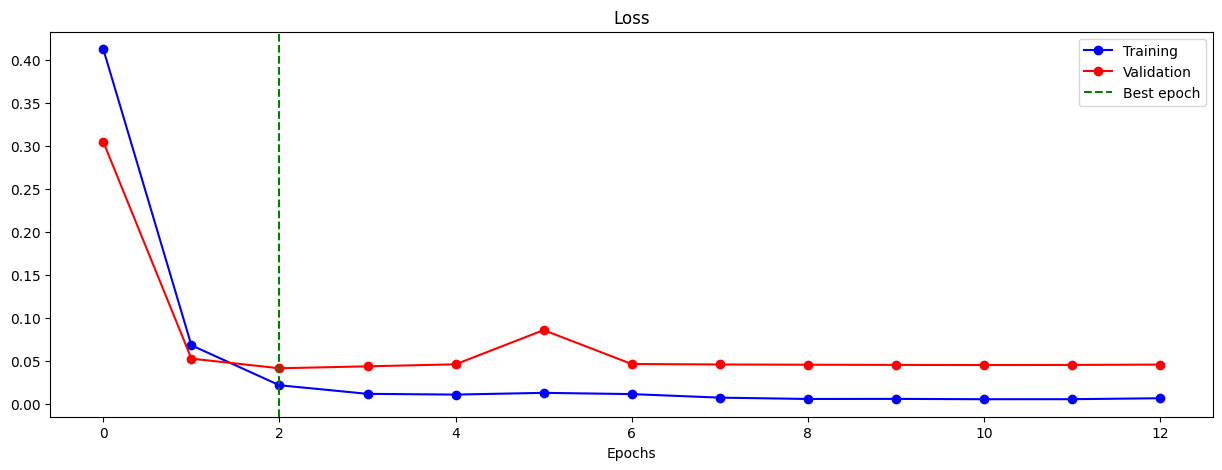

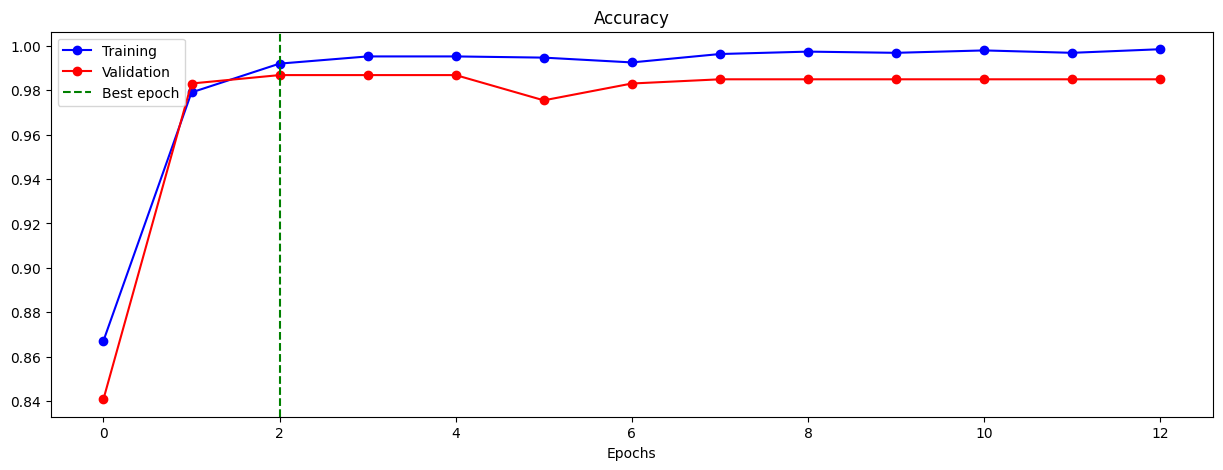

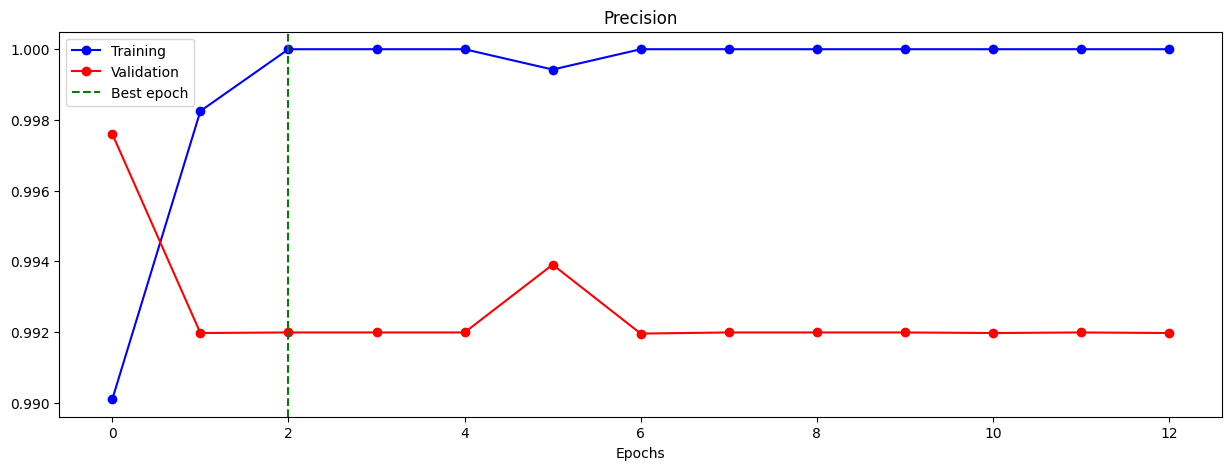

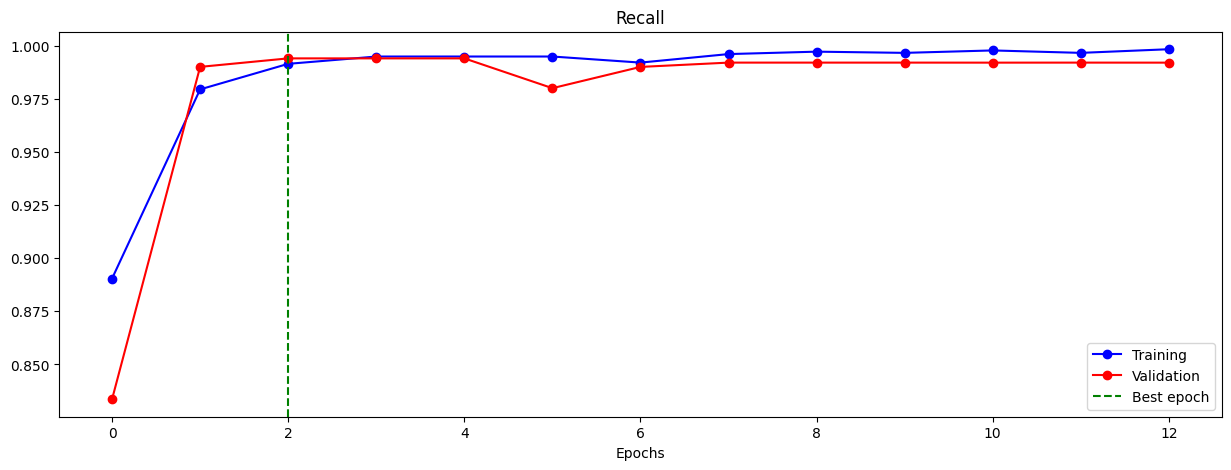

In [31]:
visualize_training_results(history)

In [32]:
def plot_metrics(model, test_data):
    # Get the predicted labels and true labels
    y_pred = model.predict(test_data)
    y_pred = y_pred > 0.5
    y_true = test_data.labels

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax1)
    ax1.set_xlabel('Predicted labels')
    ax1.set_ylabel('True labels')
    ax1.set_title('Confusion Matrix')
    ax1.xaxis.set_ticklabels(['NO OK', 'OK'])
    ax1.yaxis.set_ticklabels(['NO OK', 'OK'])

    # Calculate the true positive rate (TPR) and false positive rate (FPR) at different thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Calculate the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    ax2.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    ax2.plot([0, 1], [0, 1], linestyle='--', label='Random guessing')
    
    ax2.set_xlabel('False Positive Rate (FPR)')
    ax2.set_ylabel('True Positive Rate (TPR)')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.legend(loc="lower right")

    plt.show()
    
    # Generate the classification report
    report = classification_report(y_true, y_pred)
    # Print the report
    print(report)


2023-05-13 08:25:03.422679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


17/17 [==============================] - 37s 2s/step


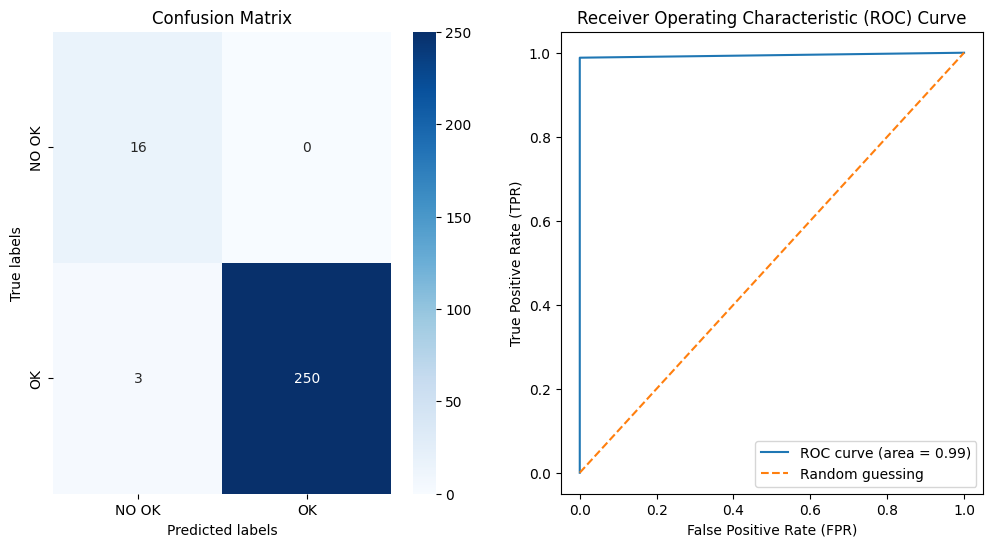

              precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       1.00      0.99      0.99       253

    accuracy                           0.99       269
   macro avg       0.92      0.99      0.95       269
weighted avg       0.99      0.99      0.99       269



In [33]:
plot_metrics(model, test_data)

In [34]:
# Print the metrics of the best epoch
best_epoch = np.argmin(history.history['val_loss'])
print("Best epoch: ", best_epoch)
print("Best loss: ", history.history['loss'][best_epoch])
print("Best accuracy: ", history.history['accuracy'][best_epoch])
print("Best recall: ", history.history['recall'][best_epoch])
print("Best precision: ", history.history['precision'][best_epoch])
print("Best val_loss: ", history.history['val_loss'][best_epoch])
print("Best val_accuracy: ", history.history['val_accuracy'][best_epoch])
print("Best val_recall: ", history.history['val_recall'][best_epoch])
print("Best val_precision: ", history.history['val_precision'][best_epoch])

Best epoch:  2
Best loss:  0.021386051550507545
Best accuracy:  0.991900622844696
Best recall:  0.9914089441299438
Best precision:  1.0
Best val_loss:  0.04113396629691124
Best val_accuracy:  0.9867424368858337
Best val_recall:  0.9939758777618408
Best val_precision:  0.991983950138092


In [ ]:
from keras.models import load_model
saved_model = load_model('model_1.h5')
plot_metrics(saved_model,test_data)